## Mask-RCNN for Ecosystem Services Dectection in Schools
Authors: Christina Xu, Chengyu Zhang

## Table of Contents
1. [Import Packages](#1-import-packages)
2. [Configure Model](#2-configure-model)
3. [Load Sample Image](#3-load-sample-image)
4. [Train Model](#4-train-model)
5. [Run Inference ](#5-run-inference)
6. [Next Steps](#6-next-steps)

### 1. Import Packages

In [1]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

import matplotlib.pyplot as plt

import tensorflow as tf

print(tf.test.is_gpu_available())
print(tf.config.list_physical_devices('GPU'))
tf.device('/gpu:0')
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
 
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join("", "./logdir/train/mask_rcnn_schools_0035.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False
[]


Using TensorFlow backend.


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,2,3,4"

print(os.getenv("CUDA_VISIBLE_DEVICES"))

0,2,3,4


### 2. Configure Model

In [3]:
class SchoolsConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "schools"
    
    # Train on 1 GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # Number of classes (including background)
    NUM_CLASSES = 1 + 5  # Background 
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 10
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.85

config = SchoolsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.85
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [4]:
from pycocotools.coco import COCO

class SchoolsDataset(utils.Dataset):

    def load_schools(self, dataset_dir, subset):
        """Load a subset of the Horse-Man dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("schools", 1, "building")
        self.add_class("schools", 2, "bush")
        self.add_class("schools", 3, "concrete")
        self.add_class("schools", 4, "grass")
        self.add_class("schools", 5, "tree")

        # Train or validation dataset?
        # assert subset in ["train", "val", "tmp"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations = json.load(open(os.path.join(dataset_dir, "annots.json")))
        #print(annotations)
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions'].values()] 
            
            schools = [s['region_attributes'] for s in a['regions'].values()]

            print("schools:",schools)

            #name_dict = {"building": 1,"bush": 2,"concrete": 3, "grass": 4, "tree": 5}
            # key = tuple(name_dict)
            num_ids = []

            for school in schools:
                try: 
                    if school['label'] == "building":
                        num_ids.append(1)
                    elif school['label'] == "bush":
                        num_ids.append(2)
                    elif school['label'] == "concrete":
                        num_ids.append(3)
                    elif school['label'] == "grass":
                        num_ids.append(4)
                    elif school['label'] == "tree":
                        num_ids.append(5)
                except:
                    pass
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "schools",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )
    
    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Horse/Man dataset image, delegate to parent class.
        # image_info = self.image_info[image_id]
        # if image_info["source"] != "object":
        #     return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        print(info["source"])
        # if info["source"] != "object":
        #     return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

### 3. Load Sample Image

schools: [{'label': 'building'}, {'label': 'concrete'}, {'label': 'concrete'}, {'label': 'tree'}, {'label': 'tree'}, {'label': 'tree'}, {'label': 'grass'}, {'label': 'building'}, {'label': 'concrete'}, {'label': 'concrete'}, {'label': 'grass'}, {'label': 'tree'}, {'label': 'grass'}, {'label': 'tree'}]
numids [1, 3, 3, 5, 5, 5, 4, 1, 3, 3, 4, 5, 4, 5]
schools: [{'label': 'building'}, {'label': 'building'}, {'label': 'building'}, {'label': 'grass'}, {'label': 'concrete'}, {'label': 'concrete'}, {'label': 'building'}]
numids [1, 1, 1, 4, 3, 3, 1]
schools: [{'label': 'building'}, {'label': 'building'}, {'label': 'building'}, {'label': 'building'}, {'label': 'building'}, {'label': 'building'}, {'label': 'building'}, {'label': 'building'}, {'label': 'concrete'}, {'label': 'concrete'}, {'label': 'concrete'}, {'label': 'tree'}, {'label': 'tree'}, {'label': 'tree'}, {'label': 'grass'}, {'label': 'building'}]
numids [1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 5, 5, 5, 4, 1]
schools: [{'label': 'building'}

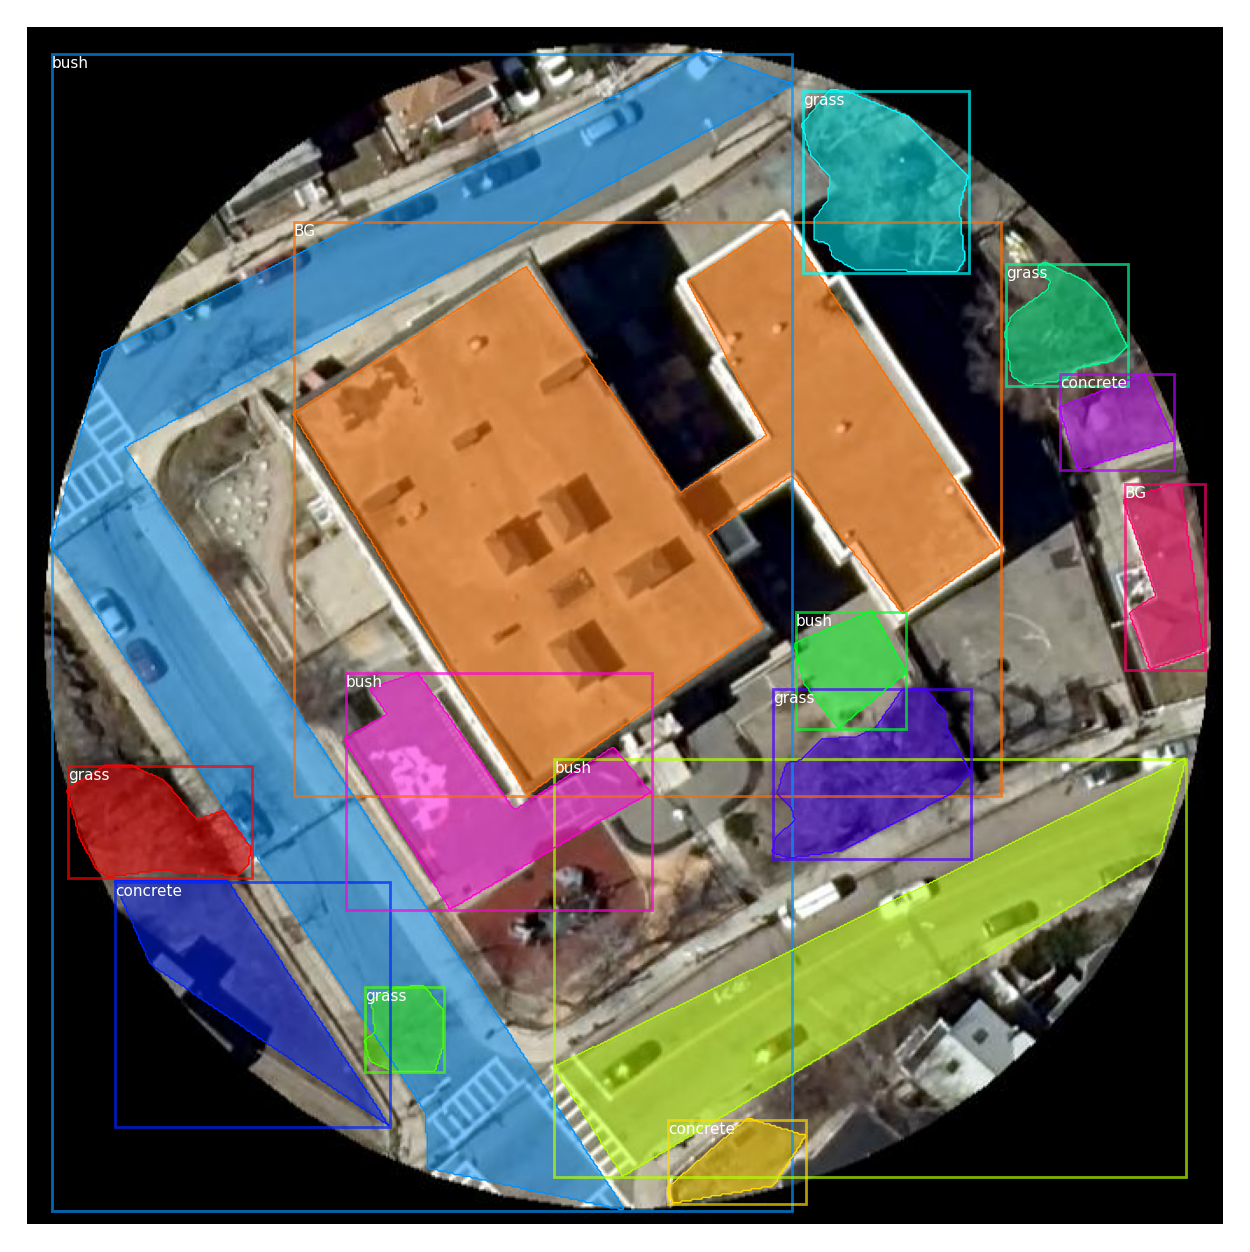

In [5]:
dataset_train = SchoolsDataset()
dataset_train.load_schools("dataset/", "train_v8") 
dataset_train.prepare()

# define image id
image_id = 0
# load the image
image = dataset_train.load_image(image_id)
# load the masks and the class ids
mask, class_ids = dataset_train.load_mask(image_id)

# display_instances(image, r1['rois'], r1['masks'], r1['class_ids'],
# dataset.class_names, r1['scores'], ax=ax, title="Predictions1")

# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

### 4. Train Model

In [7]:
import time
def train(model):
    start_time = time.time()
    # Load training dataset
    dataset_train = SchoolsDataset()
    dataset_train.load_schools("dataset", "train_v8")
    dataset_train.prepare()

    # Load testing dataset
    # dataset_val = SchoolsDataset()
    # dataset_val.load_schools("schools", "val")
    # dataset_val.prepare()

    print("Training in process...")
    model.train(dataset_train, dataset_train,
                learning_rate=config.LEARNING_RATE,
                epochs=35, 
                layers="all")
    end_time = time.time()
    minutes = round((end_time-start_time)/60, 2)
    print(f"Training took {minutes} to bcomplete.")

In [8]:
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])
train(model)

schools: [{'label': 'building'}, {'label': 'concrete'}, {'label': 'concrete'}, {'label': 'tree'}, {'label': 'tree'}, {'label': 'tree'}, {'label': 'grass'}, {'label': 'building'}, {'label': 'concrete'}, {'label': 'concrete'}, {'label': 'grass'}, {'label': 'tree'}, {'label': 'grass'}, {'label': 'tree'}]
numids [1, 3, 3, 5, 5, 5, 4, 1, 3, 3, 4, 5, 4, 5]
schools: [{'label': 'building'}, {'label': 'building'}, {'label': 'building'}, {'label': 'grass'}, {'label': 'concrete'}, {'label': 'concrete'}, {'label': 'building'}]
numids [1, 1, 1, 4, 3, 3, 1]
schools: [{'label': 'building'}, {'label': 'building'}, {'label': 'building'}, {'label': 'building'}, {'label': 'building'}, {'label': 'building'}, {'label': 'building'}, {'label': 'building'}, {'label': 'concrete'}, {'label': 'concrete'}, {'label': 'concrete'}, {'label': 'tree'}, {'label': 'tree'}, {'label': 'tree'}, {'label': 'grass'}, {'label': 'building'}]
numids [1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 5, 5, 5, 4, 1]
schools: [{'label': 'building'}

c:\Users\53112\anaconda3\envs\RCNN\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/35
schools
 9/10 [==========================>...] - ETA: 26s - loss: 3.9085schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
10/10 [==============================] - 496s 50s/step - loss: 3.7226 - val_loss: 3.1297
Epoch 2/35
schools
 9/10 [==========================>...] - ETA: 24s - loss: 2.8332schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
schools
s

### 5. Run Inference

Processing 1 images
image                    shape: (684, 683, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
1


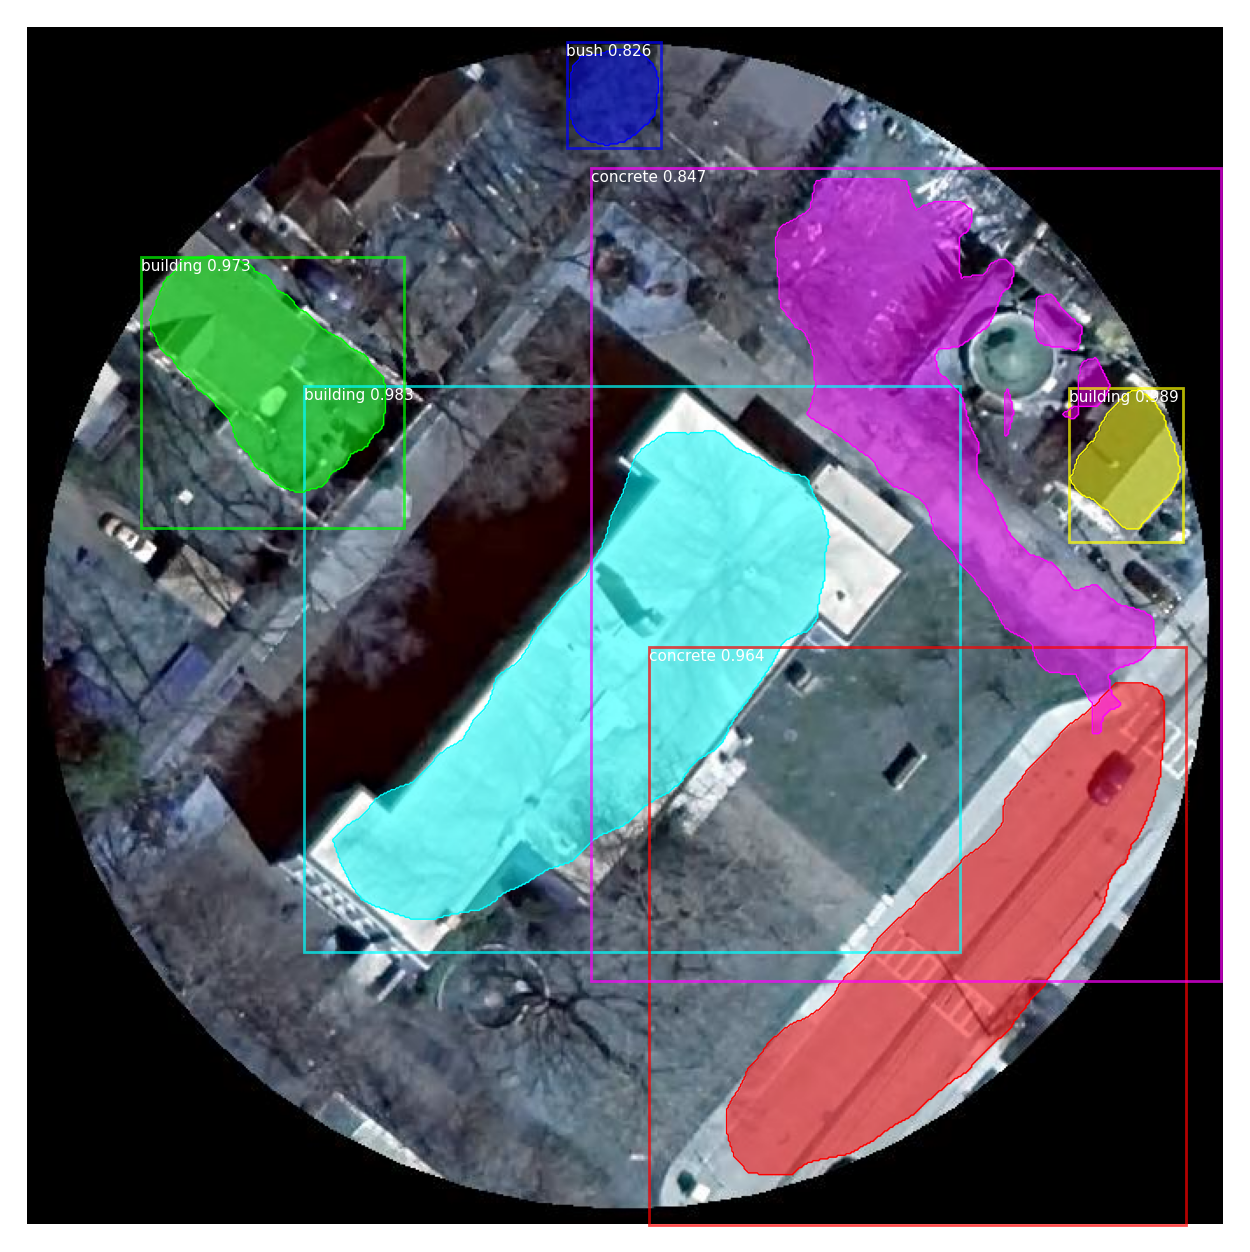

In [11]:
# Load the image you want to detect objects in
image = skimage.io.imread("./dataset/valid/Channing-_William_E__Elem_png.rf.99a2b0f909bb5b3e15a0dd1ab54408c3.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image[:,:,0:3]

# Run detection on the image
results = model.detect([image], verbose=1)

print(len(results))
# Visualize the results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            config.class_names, r['scores'])

In [13]:
dataset_val = SchoolsDataset()
dataset_val.load_schools("dataset/", "valid")
dataset_val.prepare()


# Load the configuration for your dataset
config = SchoolsConfig()

# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))


schools: [{'label': 'building'}, {'label': 'building'}, {'label': 'building'}, {'label': 'building'}, {'label': 'building'}, {'label': 'building'}, {'label': 'building'}, {'label': 'tree'}, {'label': 'grass'}, {'label': 'grass'}, {'label': 'grass'}, {'label': 'tree'}, {'label': 'grass'}, {'label': 'concrete'}, {'label': 'building'}]
numids [1, 1, 1, 1, 1, 1, 1, 5, 4, 4, 4, 5, 4, 3, 1]
schools: [{'label': 'building'}, {'label': 'building'}, {'label': 'building'}, {'label': 'building'}, {'label': 'building'}, {'label': 'concrete'}, {'label': 'grass'}, {'label': 'grass'}, {'label': 'tree'}, {'label': 'tree'}, {'label': 'tree'}, {'label': 'tree'}, {'label': 'concrete'}, {'label': 'tree'}, {'label': 'tree'}, {'label': 'grass'}, {'label': 'grass'}]
numids [1, 1, 1, 1, 1, 3, 4, 4, 5, 5, 5, 5, 3, 5, 5, 4, 4]
schools: [{'label': 'building'}, {'label': 'building'}, {'label': 'concrete'}, {'label': 'building'}]
numids [1, 1, 3, 1]
schools: [{'label': 'building'}, {'label': 'concrete'}, {'label': 

### 6. Next Steps
- Train on auxillary dataset since our dataset contains too few images to provide any utility. We are considering datasets that SegForestNet trained on such as the Toulouse dataset since it contains some of our target objects